# Notebook 02 — Signal Visualization

Visualize raw PQ disturbance waveforms from the XPQRS dataset to understand
what each disturbance class looks like.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('../src'))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import load_xpqrs, get_time_axis_ms, XPQRS_CLASSES
from visualization import plot_signal_gallery

sns.set_theme(style='whitegrid')
%matplotlib inline

np.random.seed(42)
XPQRS_DIR = '../dataset/XPQRS/'
signals, labels = load_xpqrs(XPQRS_DIR)
time_ms = get_time_axis_ms()

print(f'Loaded {signals.shape[0]} signals across {len(np.unique(labels))} classes')

Loaded 17000 signals across 17 classes


## 1. Waveform Gallery — All 17 Classes

Three random signals per class overlaid on a single subplot.

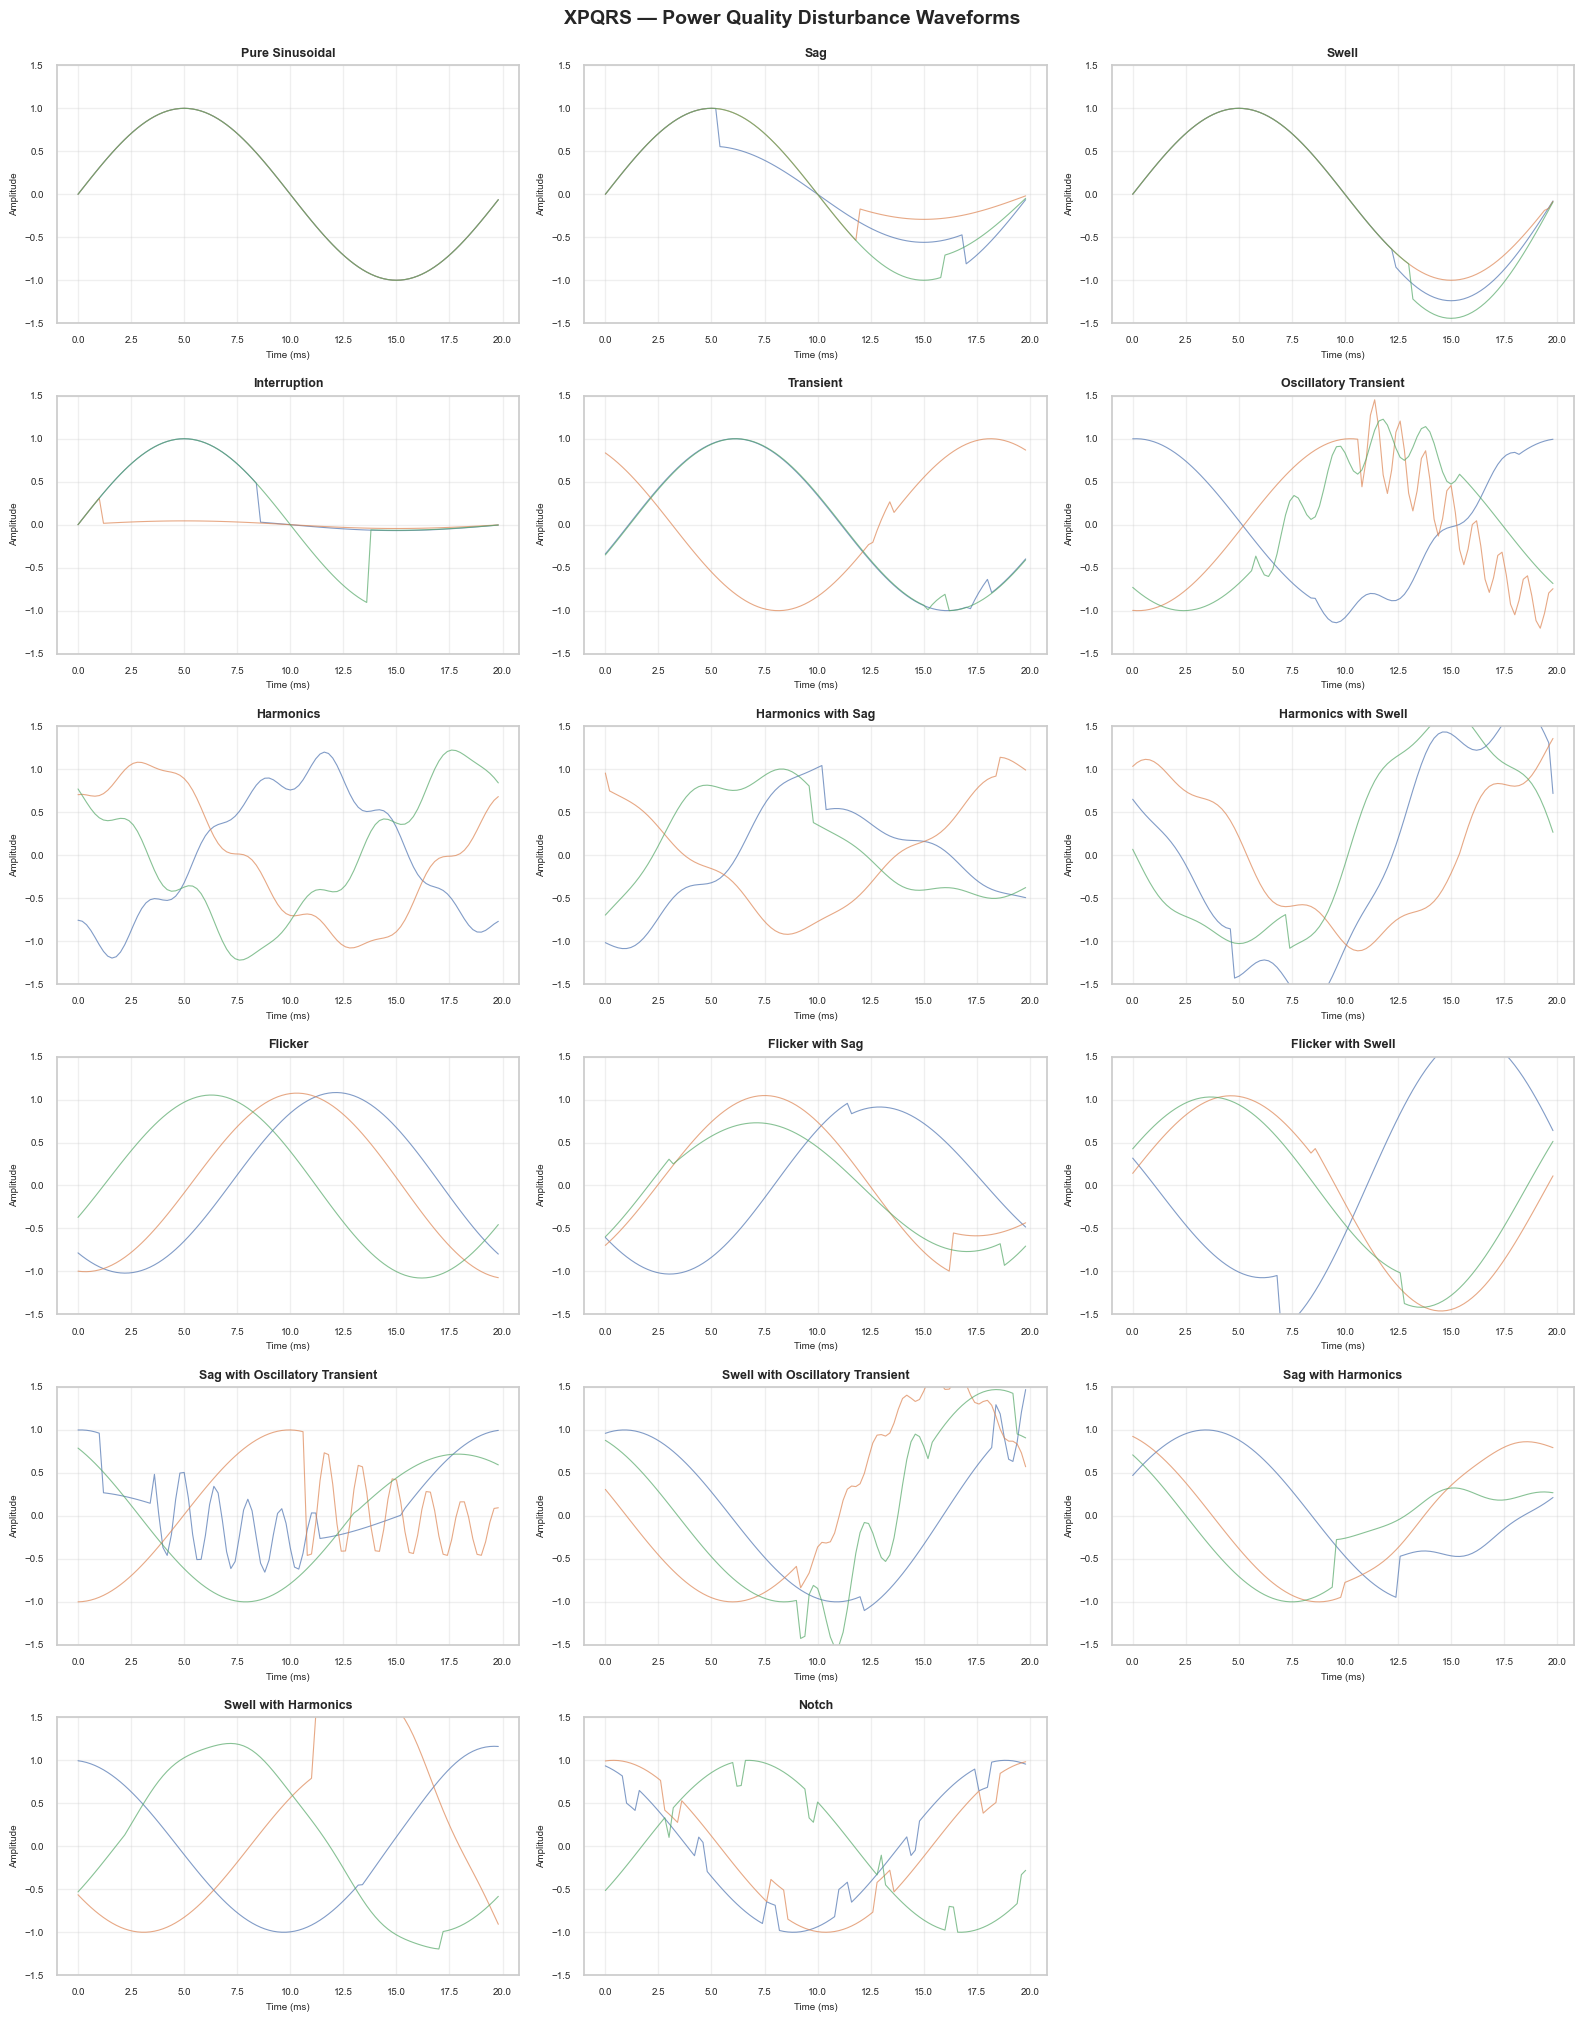

In [2]:
fig = plot_signal_gallery(signals, labels, XPQRS_CLASSES, n_examples=3, time_ms=time_ms,
                          figsize=(16, 20))
fig.suptitle('XPQRS — Power Quality Disturbance Waveforms', fontsize=14, fontweight='bold', y=1.01)
fig.savefig('../results/figures/xpqrs_waveform_gallery.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Disturbance vs. Pure Sinusoidal Comparison

Overlay one signal from each disturbance class against the Pure Sinusoidal reference.

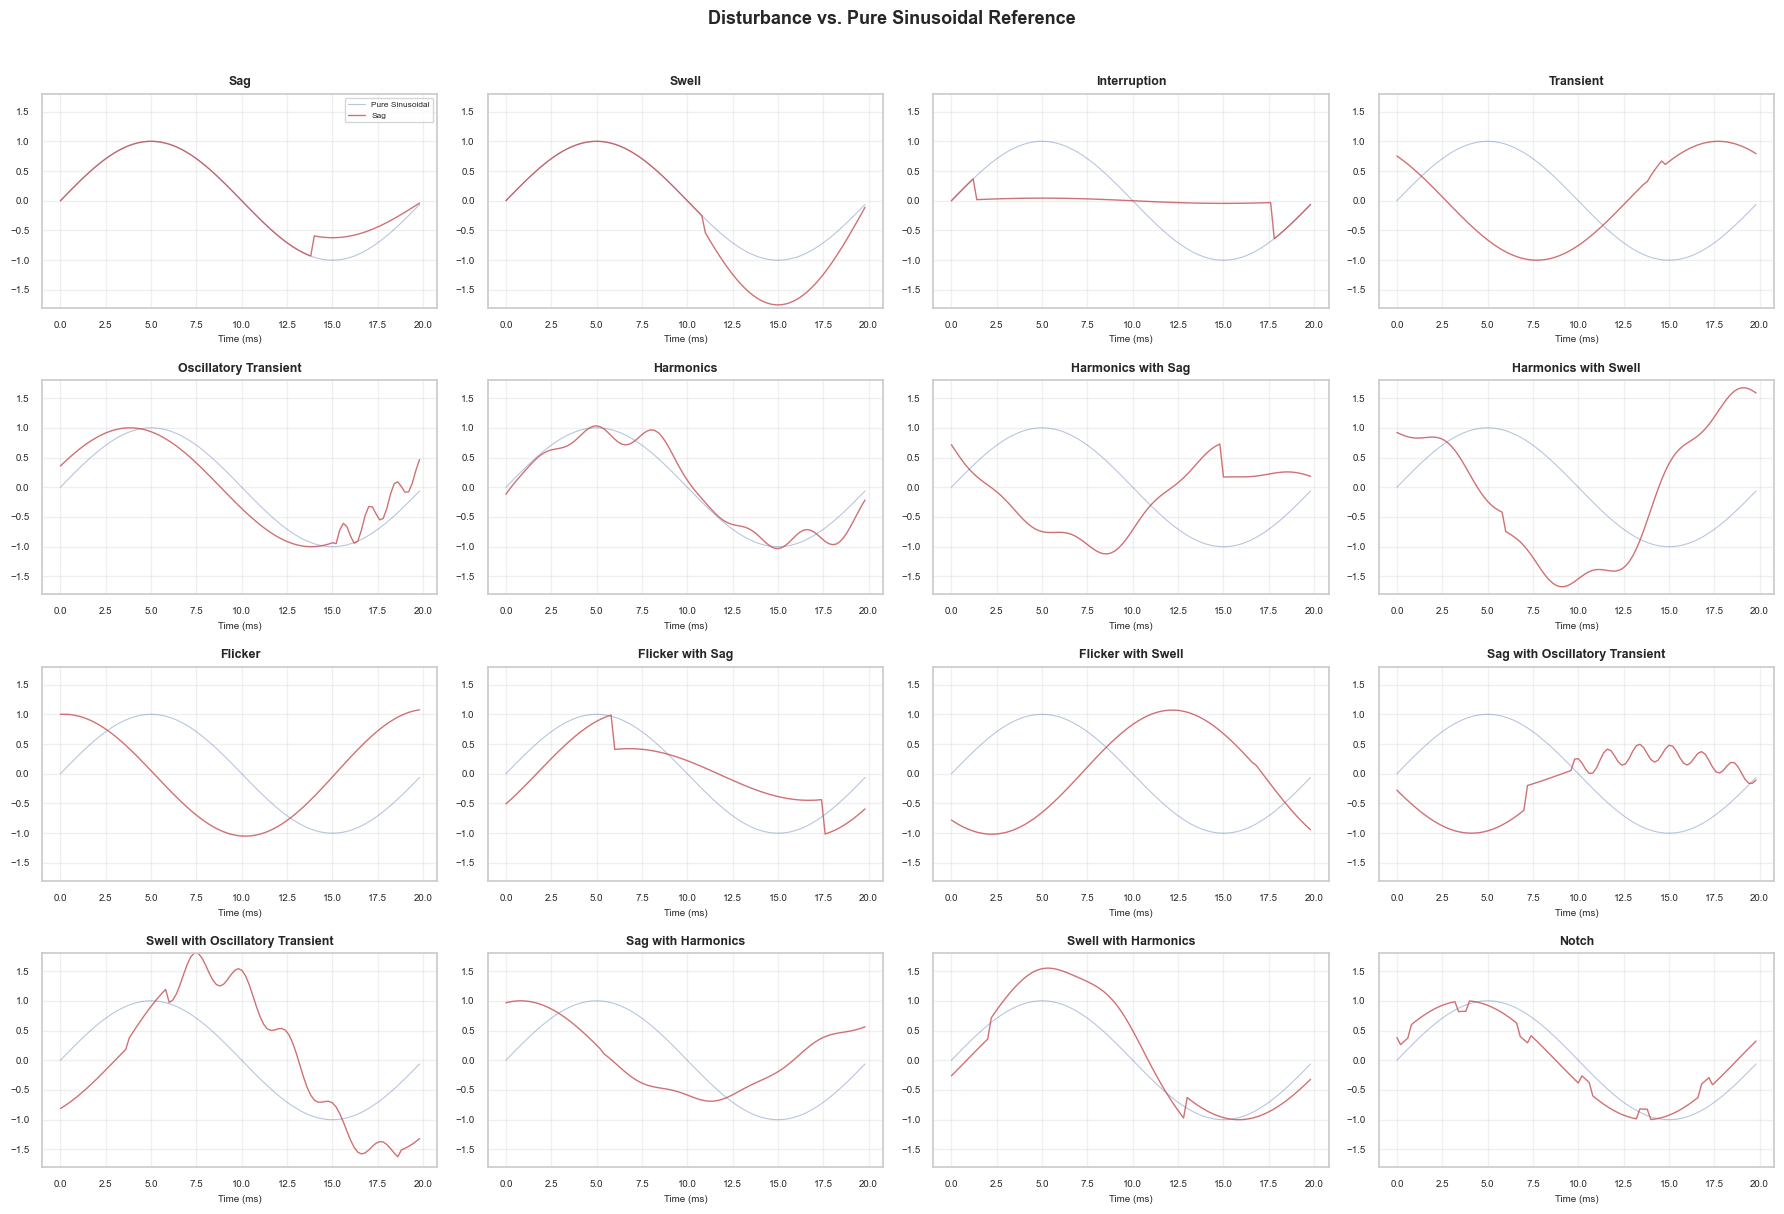

In [3]:
# Get a reference pure sinusoidal signal
ref_signal = signals[labels == 'Pure_Sinusoidal'][0]

disturbance_classes = [c for c in XPQRS_CLASSES if c != 'Pure_Sinusoidal']
ncols = 4
nrows = int(np.ceil(len(disturbance_classes) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 3 * nrows))
axes = axes.flatten()

for i, cls in enumerate(disturbance_classes):
    ax = axes[i]
    dist_signal = signals[labels == cls][0]
    ax.plot(time_ms, ref_signal, 'b-', alpha=0.4, linewidth=0.8, label='Pure Sinusoidal')
    ax.plot(time_ms, dist_signal, 'r-', alpha=0.8, linewidth=1.0, label=cls.replace('_', ' '))
    ax.set_title(cls.replace('_', ' '), fontsize=9, fontweight='bold')
    ax.set_ylim(-1.8, 1.8)
    ax.set_xlabel('Time (ms)', fontsize=7)
    ax.tick_params(labelsize=7)
    ax.grid(True, alpha=0.3)

for i in range(len(disturbance_classes), len(axes)):
    axes[i].set_visible(False)

axes[0].legend(fontsize=6)
fig.suptitle('Disturbance vs. Pure Sinusoidal Reference', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
fig.savefig('../results/figures/disturbance_vs_reference.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Amplitude Distribution per Class

Box plots showing the spread of peak amplitude values across classes.

/var/folders/n7/5wy3r6wn5833mtqwn743ynx00000gn/T/ipykernel_44437/4036587464.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=amp_df, x='Class', y='Peak Amplitude', order=order, ax=ax,
/var/folders/n7/5wy3r6wn5833mtqwn743ynx00000gn/T/ipykernel_44437/4036587464.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([c.replace('_', ' ') for c in order], rotation=45, ha='right', fontsize=8)


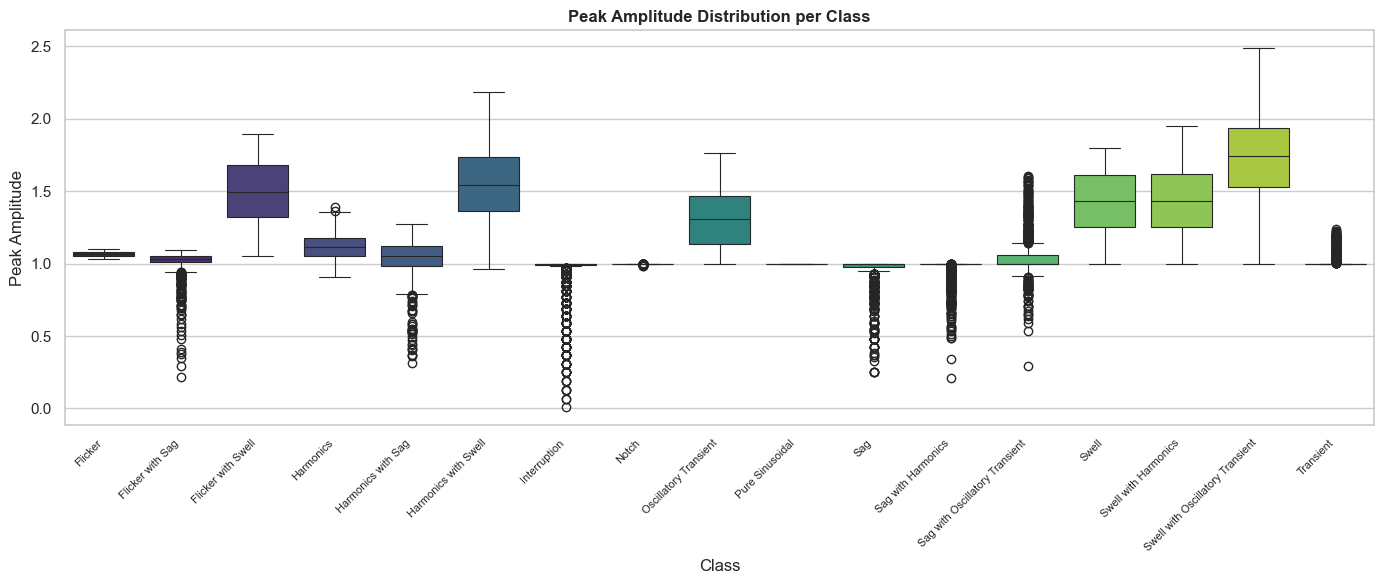

In [4]:
# Compute peak amplitude for each signal
peak_amplitudes = np.max(np.abs(signals), axis=1)

import pandas as pd
amp_df = pd.DataFrame({'Peak Amplitude': peak_amplitudes, 'Class': labels})

fig, ax = plt.subplots(figsize=(14, 6))
order = sorted(XPQRS_CLASSES)
sns.boxplot(data=amp_df, x='Class', y='Peak Amplitude', order=order, ax=ax,
            palette='viridis', linewidth=0.8)
ax.set_xticklabels([c.replace('_', ' ') for c in order], rotation=45, ha='right', fontsize=8)
ax.set_title('Peak Amplitude Distribution per Class', fontweight='bold')
plt.tight_layout()
fig.savefig('../results/figures/peak_amplitude_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. RMS Distribution per Class

/var/folders/n7/5wy3r6wn5833mtqwn743ynx00000gn/T/ipykernel_44437/4209928640.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rms_df, x='Class', y='RMS', order=order, ax=ax,
/var/folders/n7/5wy3r6wn5833mtqwn743ynx00000gn/T/ipykernel_44437/4209928640.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([c.replace('_', ' ') for c in order], rotation=45, ha='right', fontsize=8)


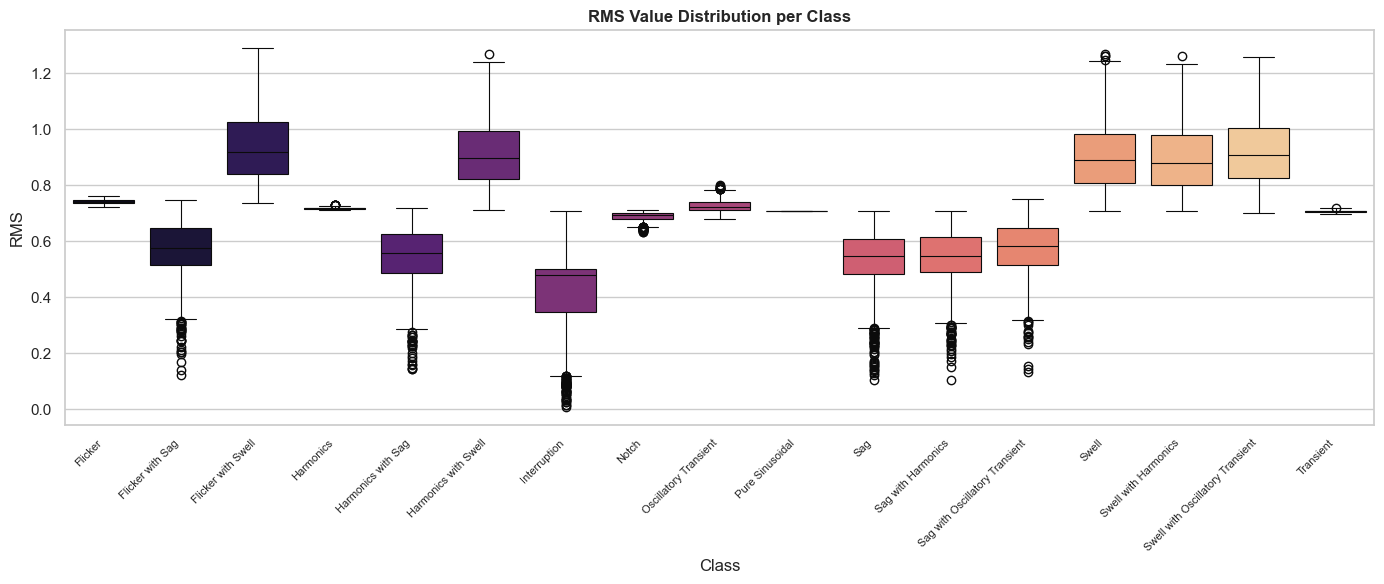

In [5]:
rms_values = np.sqrt(np.mean(signals**2, axis=1))
rms_df = pd.DataFrame({'RMS': rms_values, 'Class': labels})

fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(data=rms_df, x='Class', y='RMS', order=order, ax=ax,
            palette='magma', linewidth=0.8)
ax.set_xticklabels([c.replace('_', ' ') for c in order], rotation=45, ha='right', fontsize=8)
ax.set_title('RMS Value Distribution per Class', fontweight='bold')
plt.tight_layout()
fig.savefig('../results/figures/rms_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Frequency Spectrum Comparison

Compare the FFT magnitude spectrum for selected classes.

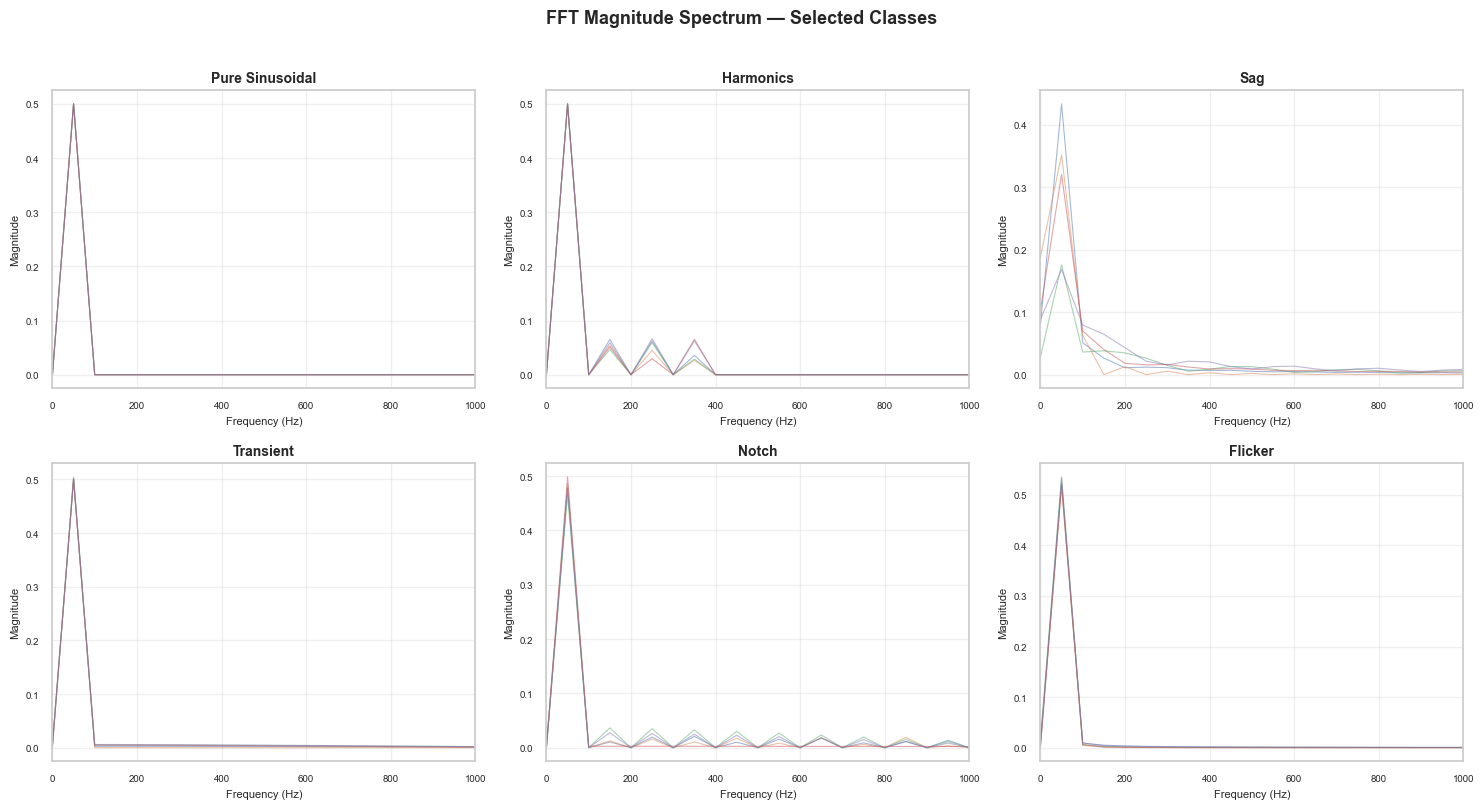

In [6]:
selected_classes = ['Pure_Sinusoidal', 'Harmonics', 'Sag', 'Transient', 'Notch', 'Flicker']
freqs = np.fft.rfftfreq(100, d=1/5000)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, cls in enumerate(selected_classes):
    ax = axes[i]
    cls_signals = signals[labels == cls][:5]
    for s in cls_signals:
        fft_mag = np.abs(np.fft.rfft(s)) / len(s)
        ax.plot(freqs, fft_mag, alpha=0.5, linewidth=0.8)
    ax.set_title(cls.replace('_', ' '), fontsize=10, fontweight='bold')
    ax.set_xlabel('Frequency (Hz)', fontsize=8)
    ax.set_ylabel('Magnitude', fontsize=8)
    ax.set_xlim(0, 1000)
    ax.tick_params(labelsize=7)
    ax.grid(True, alpha=0.3)

fig.suptitle('FFT Magnitude Spectrum — Selected Classes', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
fig.savefig('../results/figures/fft_spectrum_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
**Next:** [03_feature_extraction.ipynb](03_feature_extraction.ipynb) — Extract time, frequency, and wavelet features.